In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

pd.options.display.max_columns = None
pd.options.display.max_rows = None
    
#pd.options.display.float_format = '{:.3f}'.format

from sklearn.model_selection import train_test_split

# import functions to perform feature selection
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.feature_selection import RFE
from xgboost import XGBRegressor 
# import function to perform linear regression
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

# import functions to perform cross validation
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# import various functions from statsmodel to perform linear regression
import statsmodels
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse

# import various functions from scipy
from scipy import stats
from scipy.stats import shapiro

# 'metrics' from sklearn is used for evaluating the model performance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [5]:
def get_train_rmse(model):
    
    # For training set:
    # train_pred: prediction made by the model on the training dataset 'X_train'
    # y_train: actual values ofthe target variable for the train dataset

    # predict the output of the target variable from the train data 
    train_pred = model.predict(x_train)

    # calculate the MSE using the "mean_squared_error" function

    # MSE for the train data
    mse_train = mean_squared_error(y_train, train_pred)

    # take the square root of the MSE to calculate the RMSE
    # round the value upto 4 digits using 'round()'
    rmse_train = round(np.sqrt(mse_train), 4)
    
    # return the training RMSE
    return(rmse_train)

def get_test_rmse(model):
    
    # For testing set:
    # test_pred: prediction made by the model on the test dataset 'X_test'
    # y_test: actual values of the target variable for the test dataset

    # predict the output of the target variable from the test data
    test_pred = model.predict(x_test)

    # MSE for the test data
    mse_test = mean_squared_error(y_test, test_pred)

    # take the square root of the MSE to calculate the RMSE
    # round the value upto 4 digits using 'round()'
    rmse_test = round(np.sqrt(mse_test), 4)

    # return the test RMSE
    return(rmse_test)

def mape(actual, predicted):
    return (np.mean(np.abs((actual - predicted) / actual)) * 100)

def get_test_mape(model):
    
    # For testing set:
    # test_pred: prediction made by the model on the test dataset 'X_test'
    # y_test: actual values of the target variable for the test dataset

    # predict the output of the target variable from the test data
    test_pred = model.predict(x_test)
    
    # calculate the mape using the "mape()" function created above
    # calculate the MAPE for the test data
    mape_test = mape(y_test, test_pred)

    # return the MAPE for the test set
    return(mape_test)

def get_score(model):
    
    # score() returns the R-squared value
    r_sq = model.score(x_train, y_train)
    
    # calculate adjusted R-squared value
    # 'n' denotes number of observations in train set
    # 'shape[0]' returns number of rows 
    n = x_train.shape[0]
    
    # 'k' denotes number of variables in train set
    # 'shape[1]' returns number of columns
    k = x_train.shape[1]
    
    # calculate adjusted R-squared using the formula
    r_sq_adj = 1 - ((1-r_sq)*(n-1)/(n-k-1))
    
    # return the R-squared and adjusted R-squared value 
    return ([r_sq, r_sq_adj])

# create an empty dataframe to store the scores for various algorithms
score_card = pd.DataFrame(columns=['Model_Name', 'Alpha (Wherever Required)', 'l1-ratio', 'R-Squared',
                                       'Adj. R-Squared', 'Test_RMSE', 'Test_MAPE'])

# create a function to update the score card for comparision of the scores from different algorithms
# pass the model name, model build, alpha and l1_ration as input parameters
# if 'alpha' and/or 'l1_ratio' is not specified, the function assigns '-'
def update_score_card(algorithm_name, model, alpha = '-', l1_ratio = '-'):
    
    # assign 'score_card' as global variable
    global score_card

    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    score_card = score_card.append({'Model_Name': algorithm_name,
                       'Alpha (Wherever Required)': alpha, 
                       'l1-ratio': l1_ratio, 
                       'Test_MAPE': get_test_mape(model), 
                       'Test_RMSE': get_test_rmse(model), 
                       'R-Squared': get_score(model)[0], 
                       'Adj. R-Squared': get_score(model)[1]}, ignore_index = True)
    

def plot_coefficients(model, algorithm_name):
    # create a dataframe of variable names and their corresponding value of coefficients obtained from model
    # 'columns' returns the column names of the dataframe 'X'
    # 'coef_' returns the coefficient of each variable
    df_coeff = pd.DataFrame({'Variable': x_train.columns, 'Coefficient': model.coef_})

    # sort the dataframe in descending order
    # 'sort_values' sorts the column based on the values
    # 'ascending = False' sorts the values in the descending order
    sorted_coeff = df_coeff.sort_values('Coefficient', ascending = False)

    # plot a bar plot with Coefficient on the x-axis and Variable names on y-axis
    # pass the data to the parameter, 'sorted_coeff' to plot the barplot
    sns.barplot(x = "Coefficient", y = "Variable", data = sorted_coeff)
    
    # add x-axis label
    # set the size of the text using 'fontsize'
    plt.xlabel("Coefficients from {}".format(algorithm_name), fontsize = 15)

    # add y-axis label
    # set the size of the text using 'fontsize'
    plt.ylabel('Features', fontsize = 15)

In [15]:
LR = LinearRegression()
RF = RandomForestRegressor(random_state=10)
gbr = GradientBoostingRegressor(random_state = 100)
dcr = DecisionTreeRegressor(random_state=100)
ridge = Ridge(alpha = 1, max_iter = 500)
ridge2 = Ridge(alpha = 2, max_iter = 500)
xgb = XGBRegressor(random_state = 80)
lasso = Lasso(alpha = 0.01, max_iter = 500)
enet = ElasticNet(alpha = 0.1, l1_ratio = 0.01, max_iter = 500)

In [39]:
xgb = XGBRegressor(n_estimators = 100,max_depth = 10, max_leaves = 20,learning_rate = 0.01)

In [ ]:
lr_model = LR.fit(x_train, y_train)
rf_model = RF.fit(x_train, y_train)
gbr_model = gbr.fit(x_train, y_train)
dcr_model = dcr.fit(x_train, y_train)
ridge_model1 = ridge.fit(x_train, y_train)
ridge_model2 = ridge2.fit(x_train,y_train)
xgb_model =  xgb.fit(x_train, y_train)
lasso_model = lasso.fit(x_train,y_train)
elastic_model = enet.fit(x_train,y_train)

In [ ]:
update_score_card(algorithm_name = 'Multiple Linear Regression', model = lr_model)
update_score_card(algorithm_name = 'Random forest regressor', model = rf_model)
update_score_card(algorithm_name = 'Gradient boost regressor', model = gbr_model)
update_score_card(algorithm_name = 'Decision tree regressor', model = dcr_model)
update_score_card(algorithm_name = 'Ridge regressor 1', model = ridge_model1)
update_score_card(algorithm_name = 'Ridge regressor 2', model = ridge_model2)
update_score_card(algorithm_name = 'Xtreme Gradient boost regressor', model = xgb_model)
update_score_card(algorithm_name = 'Lasso regressor', model = lasso_model)
update_score_card(algorithm_name = 'Elastic Net', model = elastic_model)

In [67]:
rfe_23 = ['land_sqft', 'gross_sqft', 'LotArea', 'BldgArea', 'AssessLand',
       'AssessTot', 'BuiltFAR', 'ResidFAR', 'FacilFAR',
       'neighbor_clusters_high_min_low_max_neighborhood',
       'neighbor_clusters_low_min_high_max_neighborhood',
       'neighbor_clusters_low_min_low_max_neighborhood',
       'building_class_category_02 TWO FAMILY HOMES',
       'bclass_clusters_hila_bclass', 'bclass_clusters_liha_bclass',
       'bclass_clusters_lila_bclass', 'school_Group2', 'school_Group4',
       'school_Group5', 'landuse_group_Multi-Family Walk-Up Buildings',
       'landuse_group_other use', 'BsmtCode_four basements',
       'BsmtCode_no basement']

rfe_15 = ['LotArea', 'BldgArea', 'AssessLand', 'AssessTot', 'BuiltFAR',
       'neighbor_clusters_high_min_low_max_neighborhood',
       'neighbor_clusters_low_min_high_max_neighborhood',
       'neighbor_clusters_low_min_low_max_neighborhood',
       'bclass_clusters_hila_bclass', 'bclass_clusters_liha_bclass',
       'bclass_clusters_lila_bclass', 'school_Group2', 'school_Group4',
       'school_Group5', 'landuse_group_other use']

rfe_25 = ['land_sqft', 'gross_sqft', 'LotArea', 'BldgArea', 'AssessLand',
       'AssessTot', 'BuiltFAR', 'ResidFAR', 'FacilFAR', 'SHAPE_Area',
       'neighbor_clusters_high_min_low_max_neighborhood',
       'neighbor_clusters_low_min_high_max_neighborhood',
       'neighbor_clusters_low_min_low_max_neighborhood',
       'building_class_category_02 TWO FAMILY HOMES',
       'bclass_clusters_hila_bclass', 'bclass_clusters_liha_bclass',
       'bclass_clusters_lila_bclass', 'school_Group2', 'school_Group3',
       'school_Group4', 'school_Group5',
       'landuse_group_Multi-Family Walk-Up Buildings',
       'landuse_group_other use', 'BsmtCode_four basements',
       'BsmtCode_no basement']

sfs_backward = ['gross_sqft', 'LotArea', 'BldgArea', 'AssessLand', 'AssessTot',
       'BuiltFAR', 'SHAPE_Area', 'Total_alterations', 'age',
       'neighbor_clusters_high_min_low_max_neighborhood',
       'neighbor_clusters_low_min_high_max_neighborhood',
       'neighbor_clusters_low_min_low_max_neighborhood',
       'bclass_clusters_hila_bclass', 'bclass_clusters_liha_bclass',
       'bclass_clusters_lila_bclass', 'school_Group5',
       'landuse_group_One & Two Family Buildings',
       'landuse_group_other use', 'Lot_other_lots',
       'BsmtCode_four basements', 'BsmtCode_no basement',
       'BsmtCode_one basement', 'BsmtCode_three basement']

In [7]:
df = pd.read_csv('encoded_df.csv')

In [8]:
df = df.iloc[:,1:]

In [16]:
# now we run with all different set of features selected from different selection methods

In [17]:
# first with all features

In [9]:
x_train = df[df['year_of_sale'] != 9].drop(columns='sale_price')
y_train = df[df['year_of_sale'] != 9]['sale_price']
x_test = df[df['year_of_sale'] == 9].drop(columns='sale_price')
y_test = df[df['year_of_sale'] == 9]['sale_price']

In [10]:
lr_model = LR.fit(x_train, y_train)
rf_model = RF.fit(x_train, y_train)
gbr_model = gbr.fit(x_train, y_train)
dcr_model = dcr.fit(x_train, y_train)
ridge_model1 = ridge.fit(x_train,y_train)
ridge_model2 = ridge2.fit(x_train,y_train)
xgb_model =  xgb.fit(x_train, y_train)
lasso_model = lasso.fit(x_train,y_train)
elastic_model = enet.fit(x_train,y_train)

In [82]:
update_score_card(algorithm_name = 'Multiple Linear Regression', model = lr_model)
update_score_card(algorithm_name = 'Random forest regressor', model = rf_model)
update_score_card(algorithm_name = 'Gradient boost regressor', model = gbr_model)
update_score_card(algorithm_name = 'Decision tree regressor', model = dcr_model)
update_score_card(algorithm_name = 'Ridge regressor 1', model = ridge_model1,alpha = '1')
update_score_card(algorithm_name = 'Ridge regressor 2', model = ridge_model2,alpha = '2')
update_score_card(algorithm_name = 'Xtreme Gradient boost regressor', model = xgb_model)
update_score_card(algorithm_name = 'Lasso regressor', model = lasso_model,alpha = '0.01')
update_score_card(algorithm_name = 'Elastic Net', model = elastic_model,alpha = '0.1',l1_ratio = '0.01')

In [ ]:
sfs_Model = sfs(estimator= LR , k_features=,
    forward=True,
    floating=False,
    verbose=0,
    scoring=None,
    cv=5,
    n_jobs=1,
    pre_dispatch='2*n_jobs',
    clone_estimator=True,
    fixed_features=None,

In [21]:
linreg_backward = sfs(estimator = LR, k_features = 'best', forward = False,
                     verbose = 2, scoring = 'r2')

In [24]:
sfs_forward = linreg_backward.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:   12.1s finished

[2022-07-26 10:46:05] Features: 45/1 -- score: -10.892509880945235[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   11.5s finished

[2022-07-26 10:46:17] Features: 44/1 -- score: -10.717182917330671[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:   15.0s finished

[2022-07-26 10:46:32] Features: 43/1 -- score: -10.560726611176836[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Don

[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.3s finished

[2022-07-26 10:50:41] Features: 18/1 -- score: -10.147488774043246[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.0s finished

[2022-07-26 10:50:44] Features: 17/1 -- score: -10.146692080320301[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.7s finished

[2022-07-26 10:50:47] Features: 16/1 -- score: -10.146859937849324[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.4s finished

[2022-07-26 10:50:50] Features: 15/

In [25]:
linreg_backward.k_feature_names_

('neighbor_clusters_high_min_low_max_neighborhood',
 'landuse_group_One & Two Family Buildings',
 'BsmtCode_no basement')

In [20]:
linreg_forward.k_feature_names_

('BldgDepth',
 'neighbor_clusters_high_min_low_max_neighborhood',
 'BsmtCode_four basements',
 'BsmtCode_no basement')

In [28]:
x_train.head()

,land_sqft,gross_sqft,year_of_sale,LotArea,BldgArea,ResArea,NumFloors,LotFront,LotDepth,BldgFront,BldgDepth,AssessLand,AssessTot,BuiltFAR,ResidFAR,FacilFAR,SHAPE_Leng,SHAPE_Area,Total_alterations,age,neighbor_clusters_high_min_low_max_neighborhood,neighbor_clusters_low_min_high_max_neighborhood,neighbor_clusters_low_min_low_max_neighborhood,building_class_category_02 TWO FAMILY HOMES,building_class_category_03 THREE FAMILY HOMES,bclass_clusters_hila_bclass,bclass_clusters_liha_bclass,bclass_clusters_lila_bclass,school_Group2,school_Group3,school_Group4,school_Group5,landuse_group_Multi-Family Walk-Up Buildings,landuse_group_One & Two Family Buildings,landuse_group_other use,Lot_Inside,Lot_other_lots,BsmtCode_four basements,BsmtCode_no basement,BsmtCode_one basement,BsmtCode_three basement,BsmtCode_two basements,ProxCode_Detached,ProxCode_Not available,ProxCode_Semi-attached,IrrLotCode_Y
0,7.600902,8.348775,5,7.600902,8.348775,7.718685,3.0,3.218876,4.382027,3.218876,4.369448,8.645586,10.490441,0.746688,1.386294,1.386294,5.404267,7.623384,0,108,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,7.824046,8.006368,7,7.824046,8.006368,7.600902,3.0,3.218876,4.605170,3.218876,3.688879,9.170143,10.505177,0.182322,1.386294,1.386294,5.528171,7.820403,1,84,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,7.829233,9.210340,7,7.829233,8.922658,8.922658,3.0,3.218876,4.610158,3.218876,4.605170,10.489133,11.524103,1.091923,0.887891,1.568616,5.548480,7.924922,0,84,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
3,7.377759,7.822445,7,7.377759,7.822445,7.416980,2.0,2.995732,4.382027,2.772589,3.951244,8.468843,10.269969,0.444686,-0.105361,0.693147,5.325469,7.468871,0,90,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
4,7.854769,8.159375,8,7.854769,8.159375,7.758761,3.0,3.228826,4.617593,3.228826,3.583519,9.851194,11.055641,0.307485,1.098612,1.098612,5.576002,7.888821,1,106,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1


<AxesSubplot:xlabel='year_of_sale', ylabel='sale_price'>

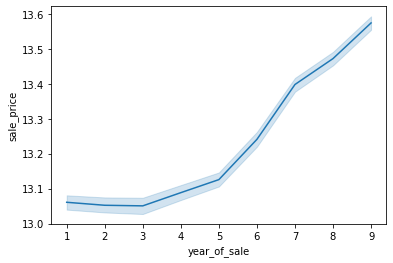

In [31]:
sns.lineplot(df['year_of_sale'],df['sale_price'])

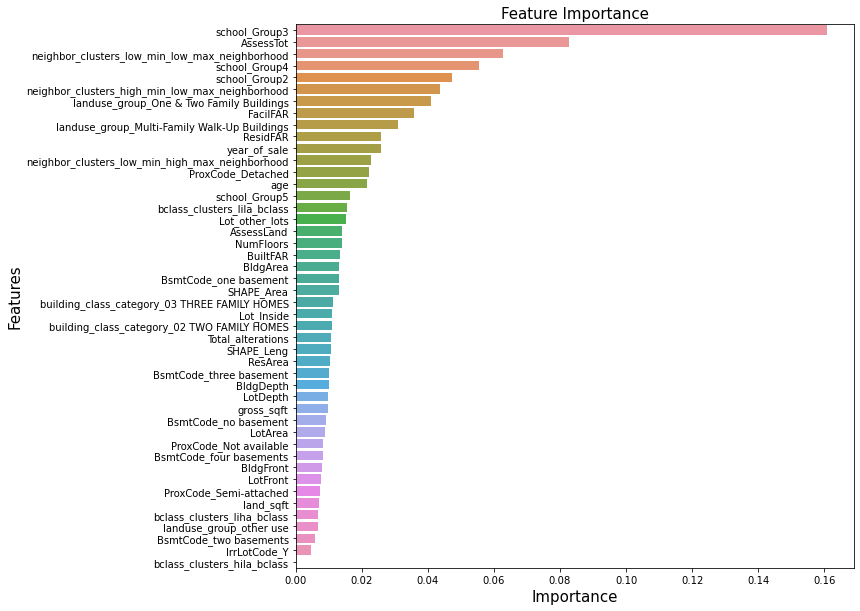

In [12]:
plt.figure(figsize=(10,10))
important_features = pd.DataFrame({'Features': x_train.columns, 
                                   'Importance': xgb_model.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

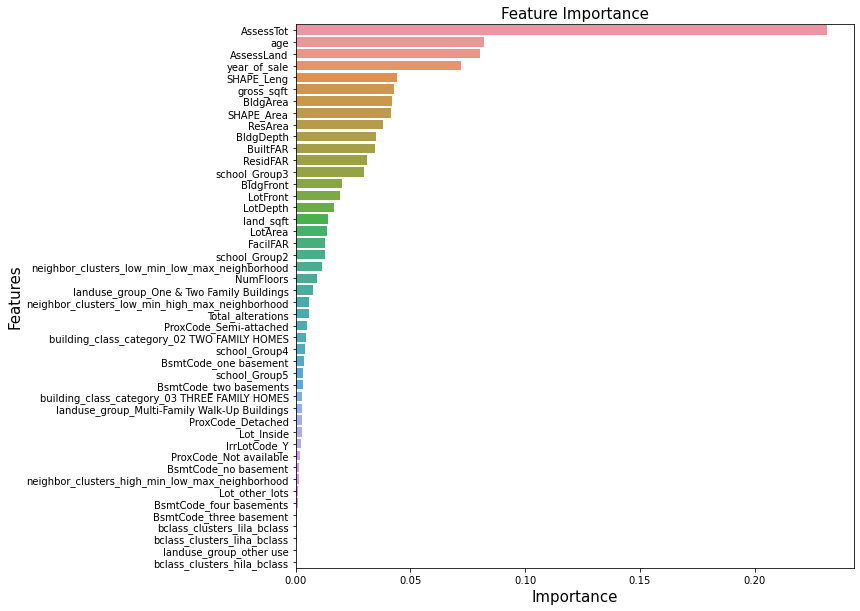

In [13]:
plt.figure(figsize=(10,10))
important_features = pd.DataFrame({'Features': x_train.columns, 
                                   'Importance': rf_model.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

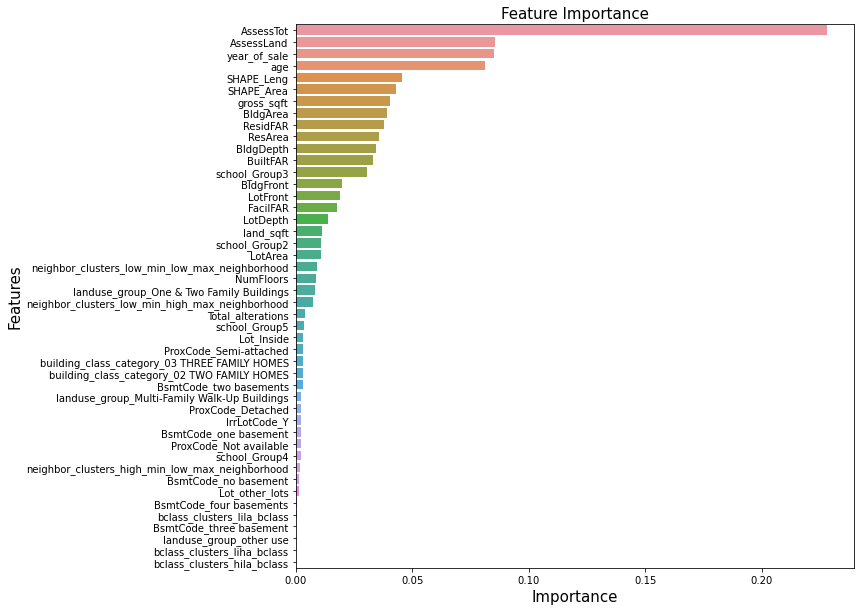

In [14]:
plt.figure(figsize=(10,10))
important_features = pd.DataFrame({'Features': x_train.columns, 
                                   'Importance': dcr_model.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

In [84]:
score_card = score_card.sort_values('Test_RMSE').reset_index(drop = True) 
score_card.style.highlight_min(color = 'lightblue', subset = 'Test_RMSE')

,Model_Name,Alpha (Wherever Required),l1-ratio,R-Squared,Adj. R-Squared,Test_RMSE,Test_MAPE
0,Gradient boost regressor,-,-,0.358454,0.357845,0.651500,3.261442
1,Xtreme Gradient boost regressor,-,-,0.570536,0.570128,0.653600,3.239983
2,Multiple Linear Regression,-,-,0.297957,0.297290,0.669200,3.332599
3,Ridge regressor 1,1,-,0.297948,0.297281,0.669200,3.332690
4,Ridge regressor 2,2,-,0.297945,0.297278,0.669200,3.332678
5,Random forest regressor,-,-,0.883390,0.883279,0.670200,3.388019
6,Lasso regressor,0.01,-,0.261567,0.260866,0.687100,3.442047
7,Elastic Net,0.1,0.01,0.254612,0.253904,0.692500,3.504363
8,Decision tree regressor,-,-,0.960421,0.960383,0.952100,4.361263


In [85]:
models = [lr_model,rf_model,gbr_model,dcr_model,ridge_model1,ridge_model2,xgb_model,lasso_model,elastic_model]
for i in models:
    print(round(i.score(x_train,y_train),4),round(i.score(x_test,y_test),4))

0.298 0.3032
0.8834 0.3011
0.3585 0.3396
0.9604 -0.4105
0.2979 0.3031
0.2979 0.3032
0.5705 0.3352
0.2616 0.2655
0.2546 0.2538


In [ ]:
RF(n_estimators = ,criterion= ,max_depth = ,min_samples_split= ,min_samples_leaf = ,max_features = )

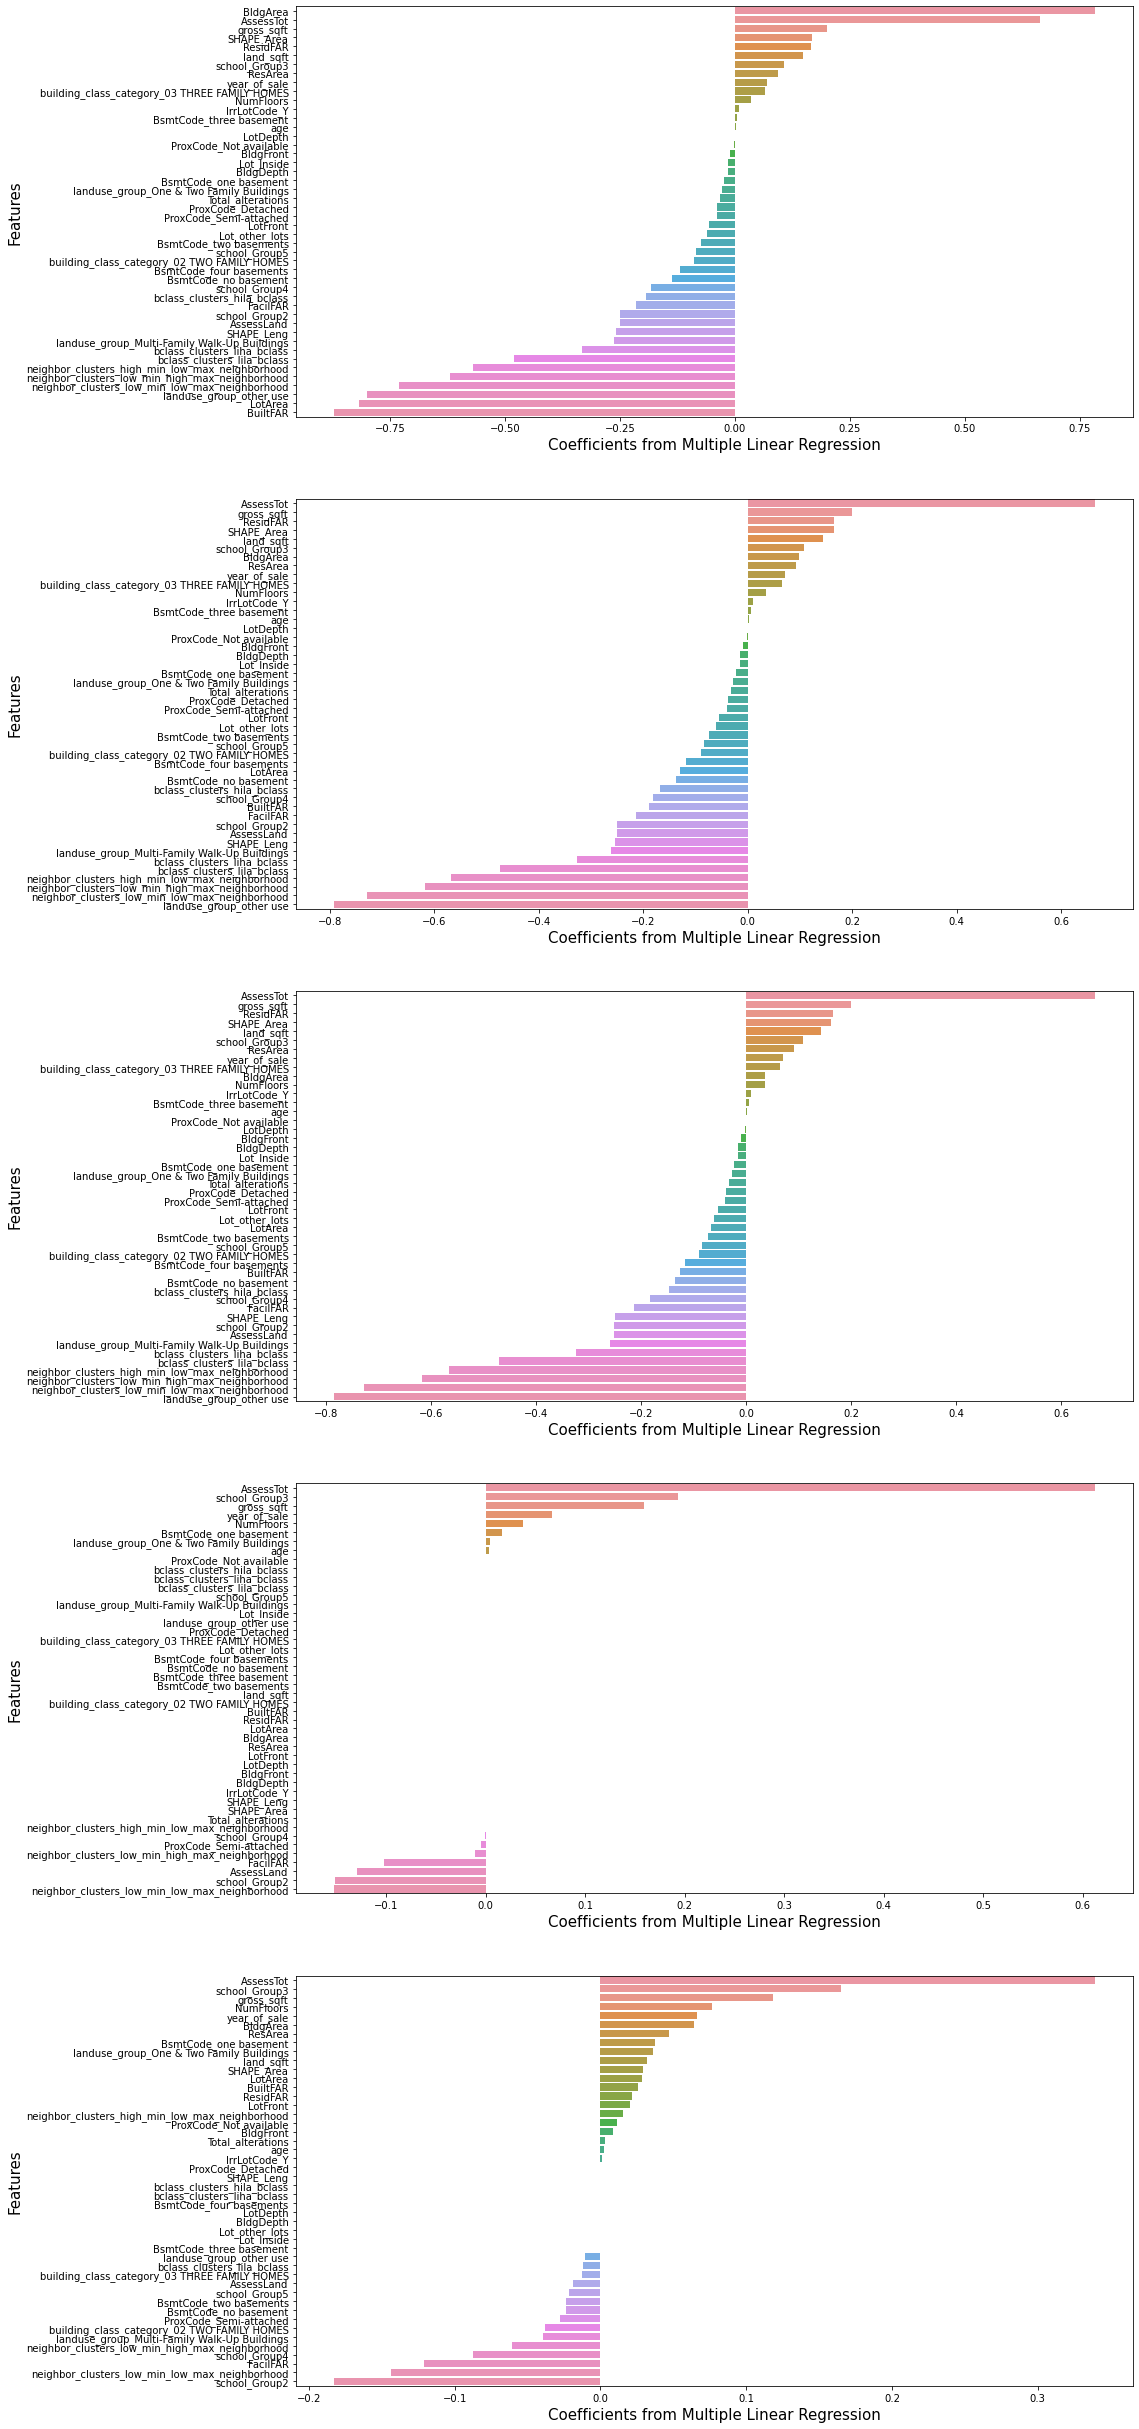

In [86]:
models1 = [lr_model,ridge_model1,ridge_model2,lasso_model,elastic_model]
plt.figure(figsize=(15,80))
a = 0
for i in models1:
    a +=1
    if (a <= 9):
        plt.subplot(9,1,a)
        plot_coefficients(i,'Multiple Linear Regression')
plt.show()

In [29]:
x_train = df[(df['year_of_sale'] != 9) & (df['year_of_sale'] != 1)&
                    (df['year_of_sale'] != 2)].drop(columns='sale_price')
y_train = df[(df['year_of_sale'] != 9) & (df['year_of_sale'] != 1)&
                    (df['year_of_sale'] != 2)]['sale_price']
x_test = df[df['year_of_sale'] == 9].drop(columns='sale_price')
y_test = df[df['year_of_sale'] == 9]['sale_price']

In [40]:
xgb_model =  xgb.fit(x_train, y_train)

In [41]:
print(round(xgb_model.score(x_train,y_train),4),round(xgb_model.score(x_test,y_test),4))

-29.4176 -37.3425


In [30]:
lr_model = LR.fit(x_train, y_train)
rf_model = RF.fit(x_train, y_train)
gbr_model = gbr.fit(x_train, y_train)
dcr_model = dcr.fit(x_train, y_train)
ridge_model1 = ridge.fit(x_train,y_train)
ridge_model2 = ridge2.fit(x_train,y_train)
xgb_model =  xgb.fit(x_train, y_train)
lasso_model = lasso.fit(x_train,y_train)
elastic_model = enet.fit(x_train,y_train)

In [32]:
update_score_card(algorithm_name = 'Multiple Linear Regression', model = lr_model)
update_score_card(algorithm_name = 'Random forest regressor', model = rf_model)
update_score_card(algorithm_name = 'Gradient boost regressor', model = gbr_model)
update_score_card(algorithm_name = 'Decision tree regressor', model = dcr_model)
update_score_card(algorithm_name = 'Ridge regressor 1', model = ridge_model1,alpha = '1')
update_score_card(algorithm_name = 'Ridge regressor 2', model = ridge_model2,alpha = '2')
update_score_card(algorithm_name = 'Xtreme Gradient boost regressor', model = xgb_model)
update_score_card(algorithm_name = 'Lasso regressor', model = lasso_model,alpha = '0.01')
update_score_card(algorithm_name = 'Elastic Net', model = elastic_model,alpha = '0.1',l1_ratio = '0.01')

In [33]:
score_card = score_card.sort_values('Test_RMSE').reset_index(drop = True) 
score_card.style.highlight_min(color = 'lightblue', subset = 'Test_RMSE')

,Model_Name,Alpha (Wherever Required),l1-ratio,R-Squared,Adj. R-Squared,Test_RMSE,Test_MAPE
0,Gradient boost regressor,-,-,0.374610,0.373864,0.650100,3.265836
1,Xtreme Gradient boost regressor,-,-,0.612411,0.611948,0.652200,3.211031
2,Multiple Linear Regression,-,-,0.315322,0.314505,0.655600,3.111154
3,Ridge regressor 1,1,-,0.315307,0.314489,0.655600,3.111485
4,Ridge regressor 2,2,-,0.315302,0.314485,0.655600,3.111407
5,Lasso regressor,0.01,-,0.278451,0.277590,0.670100,3.222914
6,Random forest regressor,-,-,0.884535,0.884397,0.671300,3.399994
7,Elastic Net,0.1,0.01,0.269290,0.268418,0.676200,3.290158
8,Decision tree regressor,-,-,0.960847,0.960800,1.008900,4.522860


In [34]:
models = [lr_model,rf_model,gbr_model,dcr_model,ridge_model1,ridge_model2,xgb_model,lasso_model,elastic_model]
for i in models:
    print(round(i.score(x_train,y_train),4),round(i.score(x_test,y_test),4))

0.3153 0.3312
0.8845 0.2987
0.3746 0.3423
0.9608 -0.5837
0.3153 0.3312
0.3153 0.3312
0.6124 0.3382
0.2785 0.3013
0.2693 0.2886


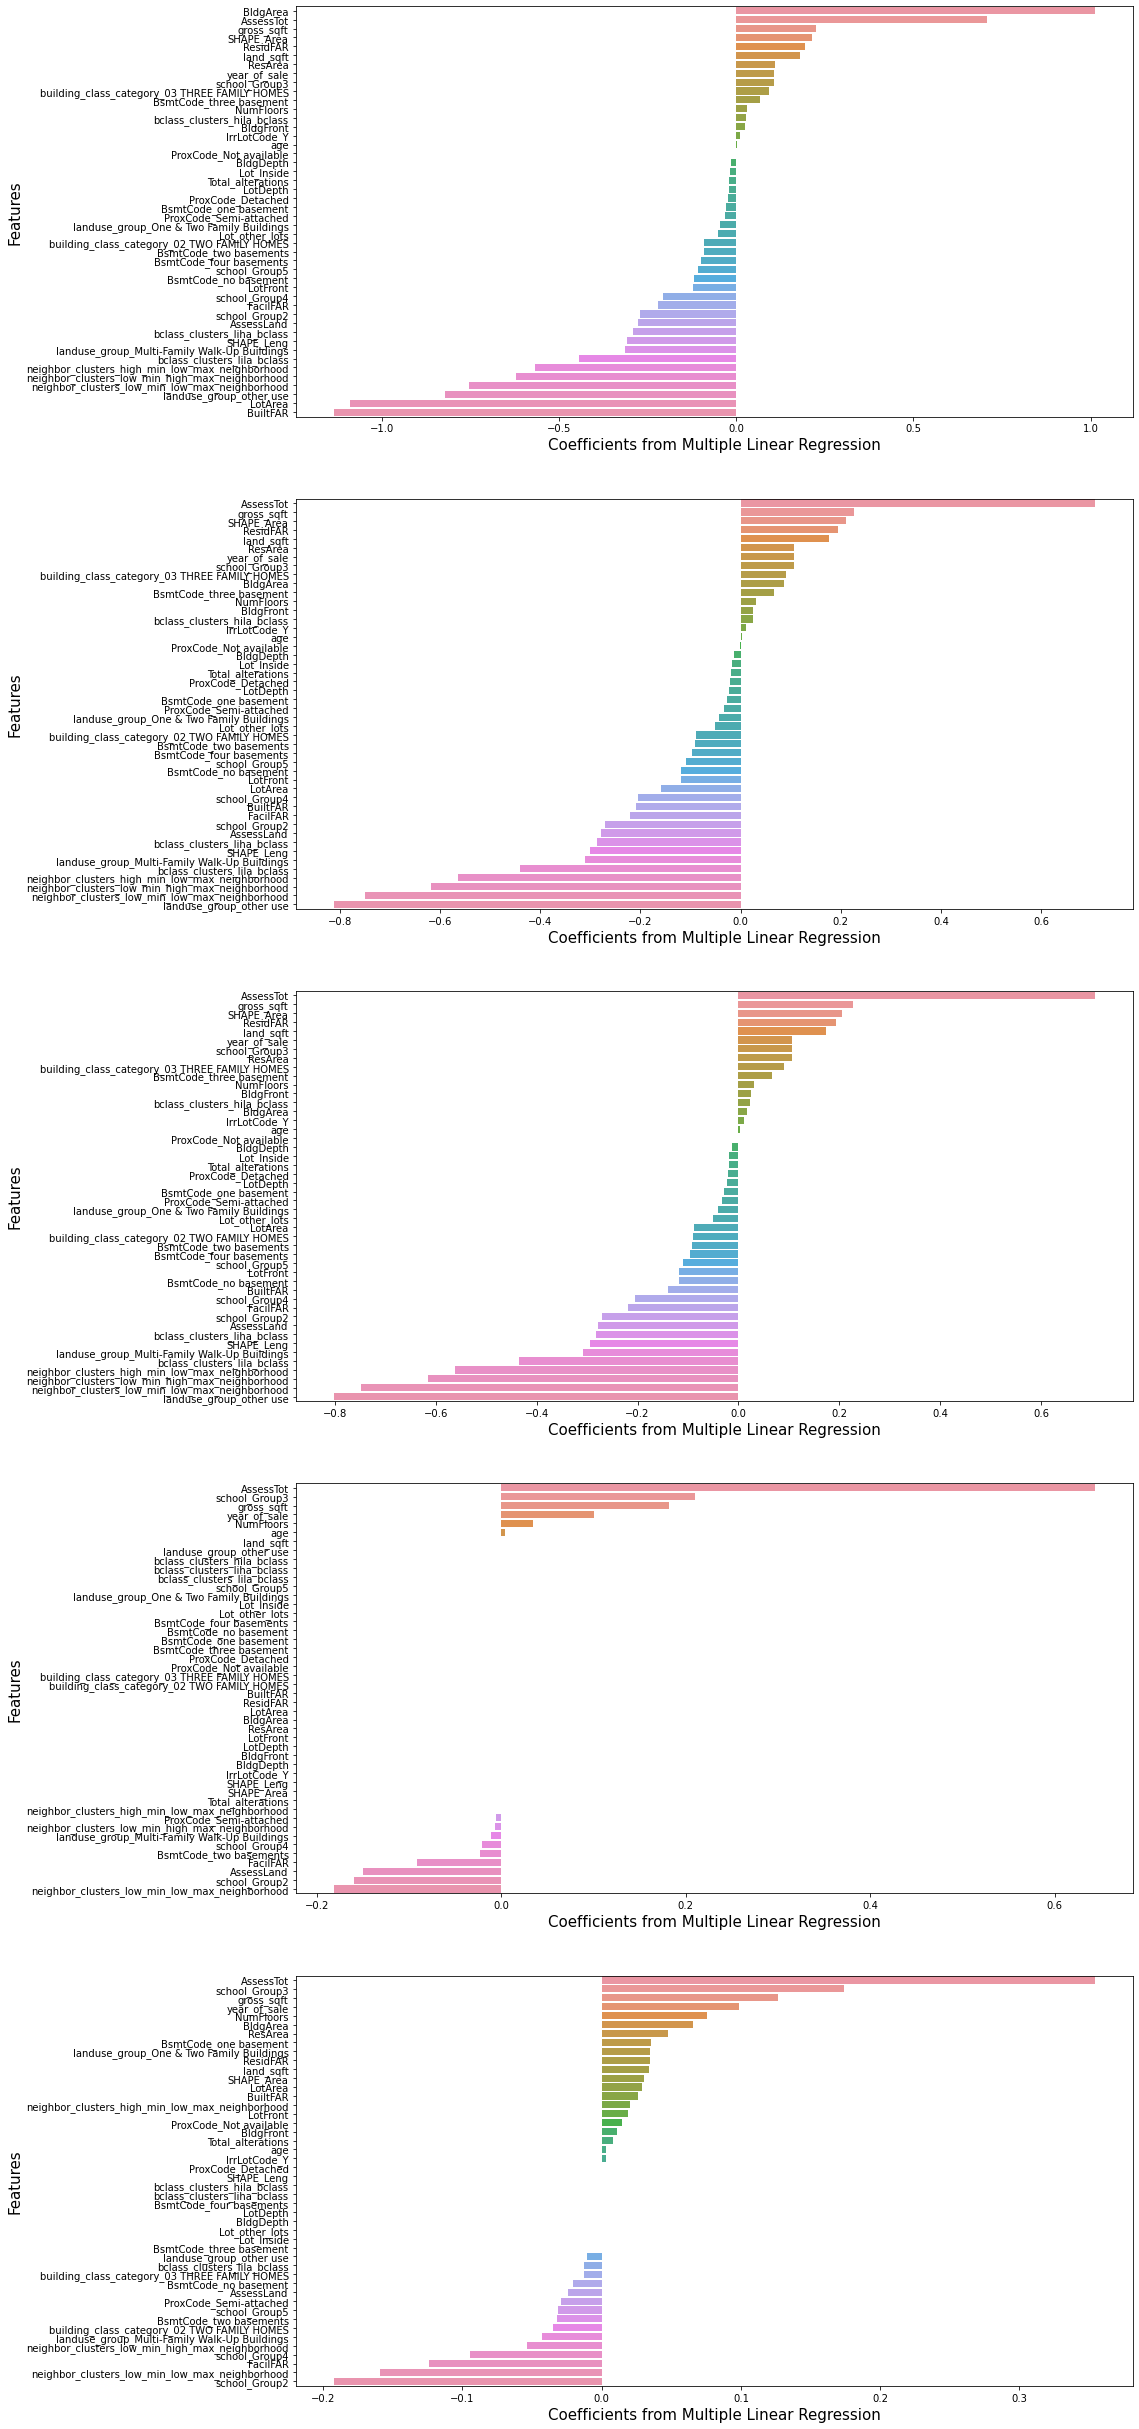

In [35]:
models1 = [lr_model,ridge_model1,ridge_model2,lasso_model,elastic_model]
plt.figure(figsize=(15,80))
a = 0
for i in models1:
    a +=1
    if (a <= 9):
        plt.subplot(9,1,a)
        plot_coefficients(i,'Multiple Linear Regression')
plt.show()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

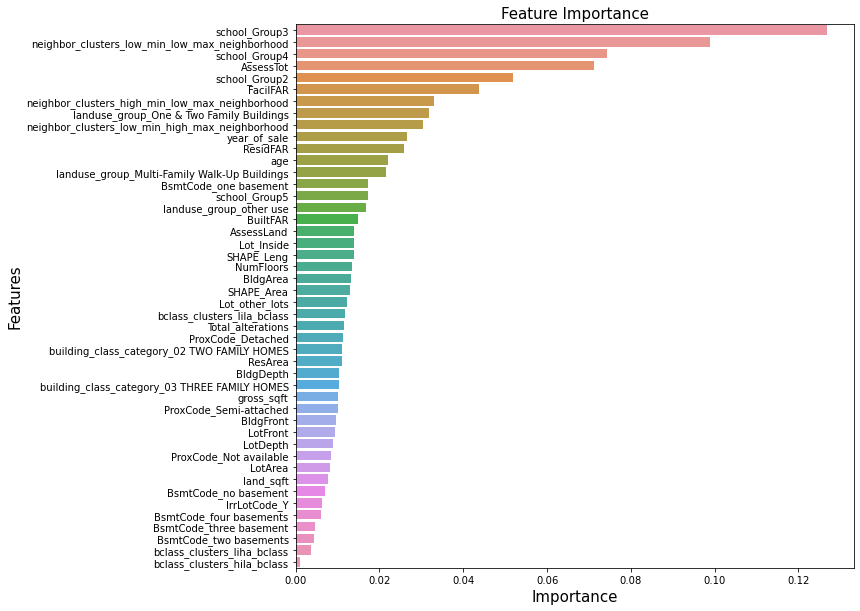

In [36]:
plt.figure(figsize=(10,10))
important_features = pd.DataFrame({'Features': x_train.columns, 
                                   'Importance': xgb_model.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

In [ ]:
xgb

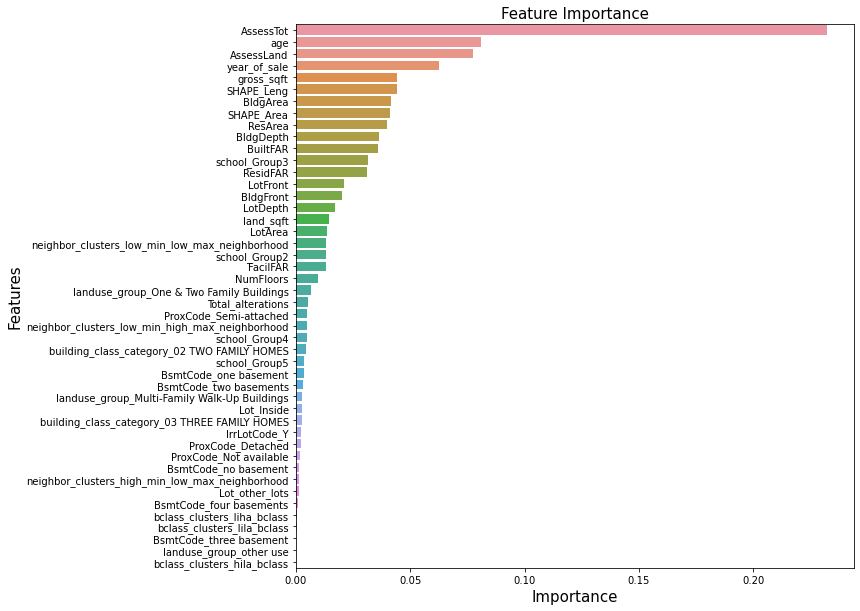

In [37]:
plt.figure(figsize=(10,10))
important_features = pd.DataFrame({'Features': x_train.columns, 
                                   'Importance': rf_model.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

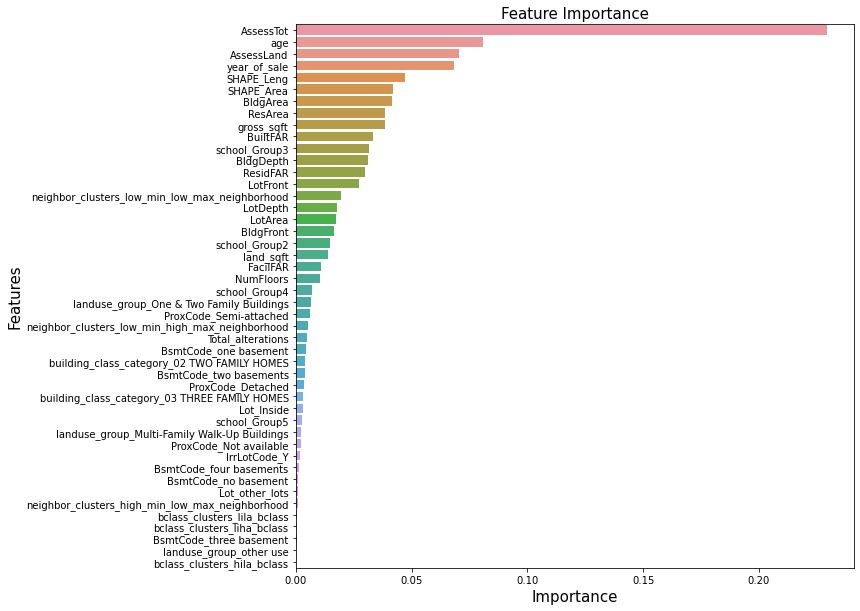

In [38]:
plt.figure(figsize=(10,10))
important_features = pd.DataFrame({'Features': x_train.columns, 
                                   'Importance': dcr_model.feature_importances_})

# sort the dataframe in the descending order according to the feature importance
important_features = important_features.sort_values('Importance', ascending = False)

# create a barplot to visualize the features based on their importance
sns.barplot(x = 'Importance', y = 'Features', data = important_features)

# add plot and axes labels
# set text size using 'fontsize'
plt.title('Feature Importance', fontsize = 15)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Features', fontsize = 15)

# display the plot
plt.show()

In [94]:
# now with backward feature selector
df_sfs = df[['gross_sqft', 'LotArea', 'BldgArea', 'AssessLand', 'AssessTot',
       'BuiltFAR', 'SHAPE_Area', 'Total_alterations', 'age',
       'neighbor_clusters_high_min_low_max_neighborhood',
       'neighbor_clusters_low_min_high_max_neighborhood',
       'neighbor_clusters_low_min_low_max_neighborhood',
       'bclass_clusters_hila_bclass', 'bclass_clusters_liha_bclass',
       'bclass_clusters_lila_bclass', 'school_Group5',
       'landuse_group_One & Two Family Buildings',
       'landuse_group_other use', 'Lot_other_lots',
       'BsmtCode_four basements', 'BsmtCode_no basement',
       'BsmtCode_one basement', 'BsmtCode_three basement','sale_price','year_of_sale']]

In [95]:
x_train = df_sfs[df_sfs['year_of_sale'] != 9].drop(columns='sale_price')
y_train = df_sfs[df_sfs['year_of_sale'] != 9]['sale_price']
x_test = df_sfs[df_sfs['year_of_sale'] == 9].drop(columns='sale_price')
y_test = df_sfs[df_sfs['year_of_sale'] == 9]['sale_price']
x_train.drop(columns = 'year_of_sale',axis = 1,inplace =True)
x_test.drop(columns = 'year_of_sale',axis = 1,inplace =True)

In [97]:
lr_model = LR.fit(x_train, y_train)
rf_model = RF.fit(x_train, y_train)
gbr_model = gbr.fit(x_train, y_train)
dcr_model = dcr.fit(x_train, y_train)
ridge_model1 = ridge.fit(x_train,y_train)
ridge_model2 = ridge2.fit(x_train,y_train)
xgb_model =  xgb.fit(x_train, y_train)
lasso_model = lasso.fit(x_train,y_train)
elastic_model = enet.fit(x_train,y_train)

In [101]:
update_score_card(algorithm_name = 'Multiple Linear Regression', model = lr_model)
update_score_card(algorithm_name = 'Random forest regressor', model = rf_model)
update_score_card(algorithm_name = 'Gradient boost regressor', model = gbr_model)
update_score_card(algorithm_name = 'Decision tree regressor', model = dcr_model)
update_score_card(algorithm_name = 'Ridge regressor 1', model = ridge_model1,alpha = '1')
update_score_card(algorithm_name = 'Ridge regressor 2', model = ridge_model2,alpha = '2')
update_score_card(algorithm_name = 'Xtreme Gradient boost regressor', model = xgb_model)
update_score_card(algorithm_name = 'Lasso regressor', model = lasso_model,alpha = '0.01')
update_score_card(algorithm_name = 'Elastic Net', model = elastic_model,alpha = '0.1',l1_ratio = '0.01')

In [102]:
score_card = score_card.sort_values('Test_RMSE').reset_index(drop = True) 
score_card.style.highlight_min(color = 'lightblue', subset = 'Test_RMSE')

,Model_Name,Alpha (Wherever Required),l1-ratio,R-Squared,Adj. R-Squared,Test_RMSE,Test_MAPE
0,Gradient boost regressor,-,-,0.298884,0.298551,0.743700,4.156741
1,Random forest regressor,-,-,0.873871,0.873811,0.750900,4.198637
2,Xtreme Gradient boost regressor,-,-,0.497749,0.497511,0.764000,4.355206
3,Multiple Linear Regression,-,-,0.232619,0.232255,0.781600,4.502756
4,Ridge regressor 1,1,-,0.232609,0.232245,0.781600,4.502832
5,Ridge regressor 2,2,-,0.232605,0.232241,0.781600,4.502960
6,Lasso regressor,0.01,-,0.199331,0.198951,0.794400,4.541610
7,Elastic Net,0.1,0.01,0.177987,0.177597,0.802700,4.562879
8,Decision tree regressor,-,-,0.960337,0.960318,1.007800,4.919814


In [ ]:
# 'NumFloors'
# 'age'
# 'year_of_sale'
# 'ResidFAR'
# 'BuiltFAR'

In [103]:
df.head()

,land_sqft,gross_sqft,year_of_sale,LotArea,BldgArea,ResArea,NumFloors,LotFront,LotDepth,BldgFront,BldgDepth,AssessLand,AssessTot,BuiltFAR,ResidFAR,FacilFAR,SHAPE_Leng,SHAPE_Area,Total_alterations,age,sale_price,neighbor_clusters_high_min_low_max_neighborhood,neighbor_clusters_low_min_high_max_neighborhood,neighbor_clusters_low_min_low_max_neighborhood,building_class_category_02 TWO FAMILY HOMES,building_class_category_03 THREE FAMILY HOMES,bclass_clusters_hila_bclass,bclass_clusters_liha_bclass,bclass_clusters_lila_bclass,school_Group2,school_Group3,school_Group4,school_Group5,landuse_group_Multi-Family Walk-Up Buildings,landuse_group_One & Two Family Buildings,landuse_group_other use,Lot_Inside,Lot_other_lots,BsmtCode_four basements,BsmtCode_no basement,BsmtCode_one basement,BsmtCode_three basement,BsmtCode_two basements,ProxCode_Detached,ProxCode_Not available,ProxCode_Semi-attached,IrrLotCode_Y
0,7.600902,8.348775,5,7.600902,8.348775,7.718685,3.0,3.218876,4.382027,3.218876,4.369448,8.645586,10.490441,0.746688,1.386294,1.386294,5.404267,7.623384,0,108,16.951005,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,7.824046,8.006368,7,7.824046,8.006368,7.600902,3.0,3.218876,4.605170,3.218876,3.688879,9.170143,10.505177,0.182322,1.386294,1.386294,5.528171,7.820403,1,84,16.705882,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,7.829233,9.210340,7,7.829233,8.922658,8.922658,3.0,3.218876,4.610158,3.218876,4.605170,10.489133,11.524103,1.091923,0.887891,1.568616,5.548480,7.924922,0,84,16.556351,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0
3,7.377759,7.822445,7,7.377759,7.822445,7.416980,2.0,2.995732,4.382027,2.772589,3.951244,8.468843,10.269969,0.444686,-0.105361,0.693147,5.325469,7.468871,0,90,16.523561,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0
4,7.854769,8.159375,8,7.854769,8.159375,7.758761,3.0,3.228826,4.617593,3.228826,3.583519,9.851194,11.055641,0.307485,1.098612,1.098612,5.576002,7.888821,1,106,16.425580,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1


In [104]:
df_new = df[['year_of_sale','NumFloors','age','ResidFAR','BuiltFAR','sale_price','neighbor_clusters_high_min_low_max_neighborhood',
'neighbor_clusters_low_min_high_max_neighborhood','neighbor_clusters_low_min_low_max_neighborhood',
'building_class_category_02 TWO FAMILY HOMES','building_class_category_03 THREE FAMILY HOMES',
'bclass_clusters_hila_bclass','bclass_clusters_liha_bclass','bclass_clusters_lila_bclass','school_Group2','school_Group3',
'school_Group4','school_Group5','landuse_group_Multi-Family Walk-Up Buildings','landuse_group_One & Two Family Buildings',
'landuse_group_other use','Lot_Inside','Lot_other_lots','BsmtCode_four basements','BsmtCode_no basement','BsmtCode_one basement',
'BsmtCode_three basement','BsmtCode_two basements','ProxCode_Detached','ProxCode_Not available','ProxCode_Semi-attached',
'IrrLotCode_Y']]

In [107]:
df = df_new

In [108]:
x_train = df[df['year_of_sale'] != 9].drop(columns='sale_price')
y_train = df[df['year_of_sale'] != 9]['sale_price']
x_test = df[df['year_of_sale'] == 9].drop(columns='sale_price')
y_test = df[df['year_of_sale'] == 9]['sale_price']

In [110]:
lr_model = LR.fit(x_train, y_train)
rf_model = RF.fit(x_train, y_train)
gbr_model = gbr.fit(x_train, y_train)
dcr_model = dcr.fit(x_train, y_train)
ridge_model1 = ridge.fit(x_train, y_train)
ridge_model2 = ridge2.fit(x_train,y_train)
xgb_model =  xgb.fit(x_train, y_train)
lasso_model = lasso.fit(x_train,y_train)
elastic_model = enet.fit(x_train,y_train)

In [112]:
update_score_card(algorithm_name = 'Multiple Linear Regression', model = lr_model)
update_score_card(algorithm_name = 'Random forest regressor', model = rf_model)
update_score_card(algorithm_name = 'Gradient boost regressor', model = gbr_model)
update_score_card(algorithm_name = 'Decision tree regressor', model = dcr_model)
update_score_card(algorithm_name = 'Ridge regressor 1', model = ridge_model1,alpha = '1')
update_score_card(algorithm_name = 'Ridge regressor 2', model = ridge_model2,alpha = '2')
update_score_card(algorithm_name = 'Xtreme Gradient boost regressor', model = xgb_model)
update_score_card(algorithm_name = 'Lasso regressor', model = lasso_model,alpha = '0.01')
update_score_card(algorithm_name = 'Elastic Net', model = elastic_model,alpha = '0.1',l1_ratio = '0.01')

In [113]:
score_card = score_card.sort_values('Test_RMSE').reset_index(drop = True) 
score_card.style.highlight_min(color = 'lightblue', subset = 'Test_RMSE')

,Model_Name,Alpha (Wherever Required),l1-ratio,R-Squared,Adj. R-Squared,Test_RMSE,Test_MAPE
0,Xtreme Gradient boost regressor,-,-,0.443593,0.443237,0.684100,3.385365
1,Gradient boost regressor,-,-,0.281823,0.281364,0.690700,3.517684
2,Multiple Linear Regression,-,-,0.216935,0.216434,0.718300,3.709723
3,Ridge regressor 1,1,-,0.216932,0.216431,0.718300,3.709599
4,Ridge regressor 2,2,-,0.216926,0.216425,0.718300,3.709526
5,Random forest regressor,-,-,0.833523,0.833416,0.725800,3.681771
6,Lasso regressor,0.01,-,0.180376,0.179852,0.733500,3.805387
7,Elastic Net,0.1,0.01,0.165377,0.164843,0.739900,3.833402
8,Decision tree regressor,-,-,0.908132,0.908073,0.978700,4.683096


In [114]:
x_train = df[(df['year_of_sale'] != 9) & (df['year_of_sale'] != 1)&
                    (df['year_of_sale'] != 2)].drop(columns='sale_price')
y_train = df[(df['year_of_sale'] != 9) & (df['year_of_sale'] != 1)&
                    (df['year_of_sale'] != 2)]['sale_price']
x_test = df[df['year_of_sale'] == 9].drop(columns='sale_price')
y_test = df[df['year_of_sale'] == 9]['sale_price']

In [115]:
lr_model = LR.fit(x_train, y_train)
rf_model = RF.fit(x_train, y_train)
gbr_model = gbr.fit(x_train, y_train)
dcr_model = dcr.fit(x_train, y_train)
ridge_model1 = ridge.fit(x_train, y_train)
ridge_model2 = ridge2.fit(x_train,y_train)
xgb_model =  xgb.fit(x_train, y_train)
lasso_model = lasso.fit(x_train,y_train)
elastic_model = enet.fit(x_train,y_train)

In [117]:
update_score_card(algorithm_name = 'Multiple Linear Regression', model = lr_model)
update_score_card(algorithm_name = 'Random forest regressor', model = rf_model)
update_score_card(algorithm_name = 'Gradient boost regressor', model = gbr_model)
update_score_card(algorithm_name = 'Decision tree regressor', model = dcr_model)
update_score_card(algorithm_name = 'Ridge regressor 1', model = ridge_model1,alpha = '1')
update_score_card(algorithm_name = 'Ridge regressor 2', model = ridge_model2,alpha = '2')
update_score_card(algorithm_name = 'Xtreme Gradient boost regressor', model = xgb_model)
update_score_card(algorithm_name = 'Lasso regressor', model = lasso_model,alpha = '0.01')
update_score_card(algorithm_name = 'Elastic Net', model = elastic_model,alpha = '0.1',l1_ratio = '0.01')

In [118]:
score_card = score_card.sort_values('Test_RMSE').reset_index(drop = True) 
score_card.style.highlight_min(color = 'lightblue', subset = 'Test_RMSE')

,Model_Name,Alpha (Wherever Required),l1-ratio,R-Squared,Adj. R-Squared,Test_RMSE,Test_MAPE
0,Xtreme Gradient boost regressor,-,-,0.462545,0.462113,0.687200,3.450598
1,Gradient boost regressor,-,-,0.288508,0.287936,0.691700,3.533771
2,Ridge regressor 2,2,-,0.228095,0.227474,0.707000,3.555868
3,Multiple Linear Regression,-,-,0.228106,0.227485,0.707100,3.556410
4,Ridge regressor 1,1,-,0.228102,0.227482,0.707100,3.556105
5,Lasso regressor,0.01,-,0.193015,0.192366,0.720000,3.651621
6,Elastic Net,0.1,0.01,0.176314,0.175651,0.726900,3.684588
7,Random forest regressor,-,-,0.830016,0.829880,0.731300,3.695598
8,Decision tree regressor,-,-,0.904698,0.904621,0.975400,4.634411


In [147]:
from sklearn.feature_selection import SequentialFeatureSelector as sfs
LR_backward = sfs(estimator= LR, n_features_to_select = 'auto',tol=1, direction='backward', scoring='r2')
sfs_backward = LR_backward.fit(x_train,y_train)

In [148]:
sfs_backward.feature_names_in_[sfs_backward.support_]

array(['neighbor_clusters_high_min_low_max_neighborhood',
       'building_class_category_02 TWO FAMILY HOMES',
       'building_class_category_03 THREE FAMILY HOMES',
       'bclass_clusters_hila_bclass', 'bclass_clusters_liha_bclass',
       'school_Group5', 'landuse_group_Multi-Family Walk-Up Buildings',
       'landuse_group_One & Two Family Buildings',
       'landuse_group_other use', 'Lot_Inside', 'BsmtCode_four basements',
       'BsmtCode_no basement', 'BsmtCode_three basement',
       'ProxCode_Not available', 'IrrLotCode_Y'], dtype=object)

In [134]:
df_sfs_new = df[['neighbor_clusters_high_min_low_max_neighborhood',
       'neighbor_clusters_low_min_high_max_neighborhood',
       'building_class_category_02 TWO FAMILY HOMES',
       'building_class_category_03 THREE FAMILY HOMES',
       'bclass_clusters_hila_bclass', 'bclass_clusters_liha_bclass',
       'school_Group5', 'landuse_group_Multi-Family Walk-Up Buildings',
       'landuse_group_One & Two Family Buildings',
       'landuse_group_other use', 'Lot_Inside', 'BsmtCode_four basements',
       'BsmtCode_no basement', 'BsmtCode_three basement',
       'ProxCode_Not available', 'IrrLotCode_Y','sale_price','year_of_sale']]

In [135]:
df = df_sfs_new

In [136]:
x_train = df[df['year_of_sale'] != 9].drop(columns='sale_price')
y_train = df[df['year_of_sale'] != 9]['sale_price']
x_test = df[df['year_of_sale'] == 9].drop(columns='sale_price')
y_test = df[df['year_of_sale'] == 9]['sale_price']
x_train.drop(columns = 'year_of_sale',axis = 1,inplace =True)
x_test.drop(columns = 'year_of_sale',axis = 1,inplace =True)

In [137]:
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
lr_model = LR.fit(x_train,y_train)

In [138]:
score_card = pd.DataFrame(columns=['Model_Name', 'Alpha (Wherever Required)', 'l1-ratio', 'R-Squared',
                                       'Adj. R-Squared', 'Test_RMSE', 'Test_MAPE'])

# create a function to update the score card for comparision of the scores from different algorithms
# pass the model name, model build, alpha and l1_ration as input parameters
# if 'alpha' and/or 'l1_ratio' is not specified, the function assigns '-'
def update_score_card(algorithm_name, model, alpha = '-', l1_ratio = '-'):
    
    # assign 'score_card' as global variable
    global score_card

    # append the results to the dataframe 'score_card'
    # 'ignore_index = True' do not consider the index labels
    score_card = score_card.append({'Model_Name': algorithm_name,
                       'Alpha (Wherever Required)': alpha, 
                       'l1-ratio': l1_ratio, 
                       'Test_MAPE': get_test_mape(model), 
                       'Test_RMSE': get_test_rmse(model), 
                       'R-Squared': get_score(model)[0], 
                       'Adj. R-Squared': get_score(model)[1]}, ignore_index = True)

In [139]:
update_score_card('linear regression', lr_model)
score_card

,Model_Name,Alpha (Wherever Required),l1-ratio,R-Squared,Adj. R-Squared,Test_RMSE,Test_MAPE
0,linear regression,-,-,0.010604,0.010278,0.8784,4.866641
